<a href="https://colab.research.google.com/github/StacyWK/Microsoft-Stock-Price-prediction-using-LSTM-model/blob/main/MS_Stock_Prediction_with_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

# If you want the exact same dataset as the YouTube video,
# use this link: https://drive.google.com/file/d/1WLm1AEYgU28Nk4lY4zNkGPSctdImbhJI/view?usp=sharing

In [3]:
#Read the MS stock dataset
import pandas as pd

df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-23,303.250000,305.399994,301.850006,304.649994,302.119720,22830200
1,2021-08-24,305.019989,305.649994,302.000000,302.619995,300.106598,18175800
2,2021-08-25,304.299988,304.589996,300.420013,302.010010,299.501678,20006100
3,2021-08-26,300.989990,302.429993,298.950012,299.089996,296.605896,17666100
4,2021-08-27,298.989990,300.869995,296.829987,299.720001,297.230652,22605700
...,...,...,...,...,...,...,...
247,2022-08-16,291.989990,294.040009,290.420013,292.709991,292.089996,18102900
248,2022-08-17,289.739990,293.350006,289.470001,291.320007,291.320007,18253400
249,2022-08-18,290.190002,291.910004,289.079987,290.170013,290.170013,17186200
250,2022-08-19,288.899994,289.250000,285.559998,286.149994,286.149994,20557200


In [4]:
#Work with only ate and close columns
df = df[['Date', 'Close']]

df

,Date,Close
0,2021-08-23,304.649994
1,2021-08-24,302.619995
2,2021-08-25,302.010010
3,2021-08-26,299.089996
4,2021-08-27,299.720001
...,...,...
247,2022-08-16,292.709991
248,2022-08-17,291.320007
249,2022-08-18,290.170013
250,2022-08-19,286.149994


In [5]:
#View date, and confirm it is string values
df['Date']

0      2021-08-23
1      2021-08-24
2      2021-08-25
3      2021-08-26
4      2021-08-27
          ...    
247    2022-08-16
248    2022-08-17
249    2022-08-18
250    2022-08-19
251    2022-08-22
Name: Date, Length: 252, dtype: object

In [6]:
#Convert date from string to datetime
import datetime

def str_to_datetime(s):
  #s.split splits the date string along the hyphen
  split = s.split('-') 
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

#Testing the function
datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [7]:
df

,Date,Close
0,2021-08-23,304.649994
1,2021-08-24,302.619995
2,2021-08-25,302.010010
3,2021-08-26,299.089996
4,2021-08-27,299.720001
...,...,...
247,2022-08-16,292.709991
248,2022-08-17,291.320007
249,2022-08-18,290.170013
250,2022-08-19,286.149994


In [8]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0     2021-08-23
1     2021-08-24
2     2021-08-25
3     2021-08-26
4     2021-08-27
         ...    
247   2022-08-16
248   2022-08-17
249   2022-08-18
250   2022-08-19
251   2022-08-22
Name: Date, Length: 252, dtype: datetime64[ns]

In [15]:
df.index = df.pop('Date')
df

KeyError: ignored

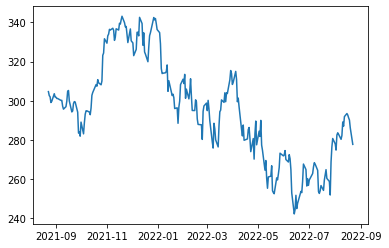

In [10]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [16]:
df.tail

<bound method NDFrame.tail of                  Close
Date                  
2021-08-23  304.649994
2021-08-24  302.619995
2021-08-25  302.010010
2021-08-26  299.089996
2021-08-27  299.720001
...                ...
2022-08-16  292.709991
2022-08-17  291.320007
2022-08-18  290.170013
2022-08-19  286.149994
2022-08-22  277.750000

[252 rows x 1 columns]>

In [18]:
#In order to use lstm model, the function below converts the problem into a supervised problem
import numpy as np

#n = 3 means 3 targets, ie if current date is 2021-08-26, target 3 is the stock price of 3 stock days from the current date
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-08-26' to '2022-08-22', '2021-08-26' is the 4th date since we can't start with the 1st date because of the 3 required targets
windowed_df = df_to_windowed_df(df, 
                                '2021-08-26', 
                                '2022-08-22' , 
                                n=3)
windowed_df
#Target 1-3 are feed into model and the target is the expected output (Target is the actual closing price for the current date)
#Below is the converted supervised problem

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-08-26,304.649994,302.619995,302.010010,299.089996
1,2021-08-27,302.619995,302.010010,299.089996,299.720001
2,2021-08-30,302.010010,299.089996,299.720001,303.589996
3,2021-08-31,299.089996,299.720001,303.589996,301.880005
4,2021-09-01,299.720001,303.589996,301.880005,301.829987
...,...,...,...,...,...
244,2022-08-16,287.019989,291.910004,293.470001,292.709991
245,2022-08-17,291.910004,293.470001,292.709991,291.320007
246,2022-08-18,293.470001,292.709991,291.320007,290.170013
247,2022-08-19,292.709991,291.320007,290.170013,286.149994


In [19]:
#Converting to numpy arrays so as to feed directly to tensorflow model using the function below
#Windowed_df from above is converted into date, X (3D matrix with the 3 targets) y(the output factor, ie the target)
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  #Get dates, : means get all rows, 0 means just the first column
  dates = df_as_np[:, 0]

  #Get nput matrix, : means get all rows, 1:-1 means starting at second column until but not including the last column
  middle_matrix = df_as_np[:, 1:-1]
  #Reshape 3D model, len(dates) - the first dimension, ie, observation, middle_matrix.shape[1]- equal to n value, no of columns, 1 - no of variables being used, ie, just closing price but checking how it changes over time (time series - univariate forecasting)
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  #Get dates, : means get all rows, -1 means just the last column
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

#call function
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((249,), (249, 3, 1), (249,))

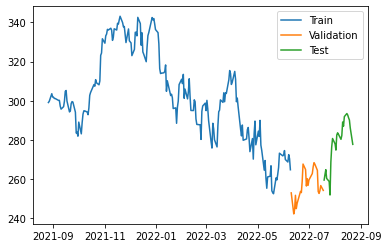

In [20]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

#Use 80% to train model
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

#Use values between 80% and 90% to validate model
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

#Use values from 90% to 100% to test model
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [23]:
#Train and validate model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

#Sequential means the model is made up of many sequential models
#1st model-Input((3, 1)- 3(3 targets), 1(one variable - closing price)
#2nd model - LSTM(64) - 64 - no of neurons
#3rd and 4th models - Dense(32, activation='relu') - 32 - no of neurons
#5th model - Dense(1) - output of the model, 1 - no of expected output variables - closing price
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.002),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
#The val_mean_absolute_error is the difference between the actual closing price and the model's prediction, the learning_rate=0.002 in this case creates an ideal val_mean_absolute_error 

Epoch 1/100
7/7 [==============================] - 3s 92ms/step - loss: 91680.1328 - mean_absolute_error: 301.9453 - val_loss: 65603.6016 - val_mean_absolute_error: 256.0278
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 91180.9141 - mean_absolute_error: 301.1178 - val_loss: 65180.6562 - val_mean_absolute_error: 255.2004
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 90658.0469 - mean_absolute_error: 300.2445 - val_loss: 64588.3516 - val_mean_absolute_error: 254.0373
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 89850.1328 - mean_absolute_error: 298.8960 - val_loss: 63757.1562 - val_mean_absolute_error: 252.3960
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 88691.3047 - mean_absolute_error: 296.9530 - val_loss: 62373.9844 - val_mean_absolute_error: 249.6409
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 86800.3828 - mean_absolute_error: 293.7645 - val_loss: 60572.65

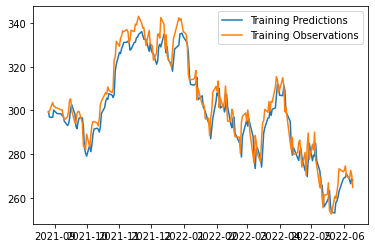

In [24]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

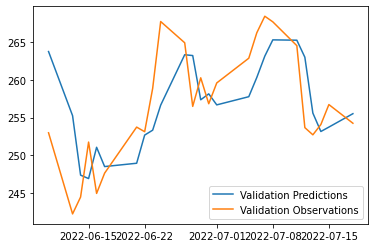

In [25]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

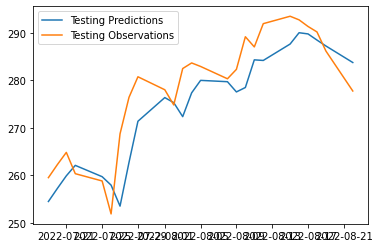

In [26]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

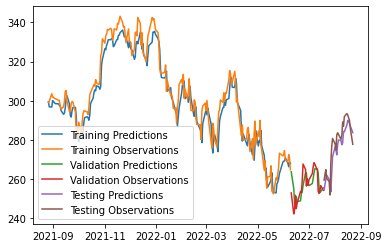

In [27]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [32]:
#Long-term prediction - 1
from copy import deepcopy

recursive_predictions = []
#Predict tor dates between validation and test dates
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])  
  #predict next day closing price
  next_prediction = model.predict(np.array([last_window])).flatten()
  #Add to list
  recursive_predictions.append(next_prediction)
  #Update last_window
  last_window[-1] = next_prediction



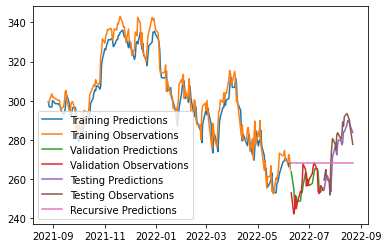

In [33]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

In [30]:
#Long-term prediction -2
from copy import deepcopy

recursive_predictions = []
recursive_dates = dates_test[-14:]
last_window  = X_test[-14]

for target_date in recursive_dates:
    print(last_window)
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    new_window = list(last_window[1:])
    new_window.append(next_prediction)
    new_window = np.array(new_window)
    last_window = new_window



[[280.74]
 [278.01]
 [274.82]]
[[278.01   ]
 [274.82   ]
 [272.35663]]
[[274.82   ]
 [272.35663]
 [269.88257]]
[[272.35663]
 [269.88257]
 [267.60706]]
[[269.88257]
 [267.60706]
 [265.52023]]
[[267.60706]
 [265.52023]
 [263.64728]]
[[265.52023]
 [263.64728]
 [261.99347]]
[[263.64728]
 [261.99347]
 [260.55652]]
[[261.99347]
 [260.55652]
 [259.32574]]
[[260.55652]
 [259.32574]
 [258.28494]]
[[259.32574]
 [258.28494]
 [257.41455]]
[[258.28494]
 [257.41455]
 [256.69342]]
[[257.41455]
 [256.69342]
 [256.10077]]
[[256.69342]
 [256.10077]
 [255.6169 ]]


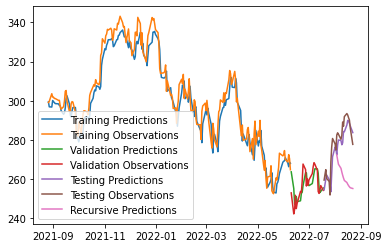

In [31]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])